## Neural network classifiers
- The aim of this notebook is to present a classifier for the MNIST dataset. The general architecture can be used for other image-classifiers. If the input is a vector instead then the convolutional layer will have to be changed, but most of the principles still apply.
- The model produced has a testing accuracy of 97%! This is encouraging but be aware: the MNIST dataset is an extremely simple one. In general, it is much harder to get good performances on things like CIFAR. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# torchvision.datasets includes a series of image and video datasets
from torchvision.datasets import MNIST
from torchvision.transforms import (ToTensor)

### Uploading the data and transforming it
- First we download the MNIST dataset, and convert the 28*28 images into Tensors. We separate into a training and testing set. 
- Then we use the `DataLoader`, which is a class which enables us to efficiently load and process the data into mini-batches for training and testing. Specifically, `train_loader` and `test_loader` are instances of the `DataLoader` class. What are these? They are objects over which we can iterate (see below during the training chunk of code) and at each iteration we get a batch of images and labels. That is, when we do `images, labels = next(iter(train_loader))` we get a tensor of size (batch_size, channels, height, width). In our case this is just (64,1,28,28) since the images are in a greyscale so there's only 1 channel, and the images are 28*28.

In [3]:
(mnist_train,
mnist_test) = [MNIST(root='data', train=train, download=True, transform=ToTensor()) for train in [True, False]]

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

### The model (convolutional layers, pooling, padding and dropout)
- Let's explain the different layers in our neural network:

| Type of Layer    | Explanation                                                                 |
|------------------|-----------------------------------------------------------------------------|
| Linear           | `nn.Linear(n, m)` applies a linear transformation $x \to Ax$, where $A$ is an $m \times n$ matrix. |
| Convolutional    | `nn.Conv2d(in_channels, out_channels, kernel_size, padding)`, where:<br> (1) The input tensor will have shape `(in_channels, height, width)`, in a greyscale image this is equal to 1, in RGB it'll be equal to 3.<br> (2) This layer will output `out_channels` number of images, each of which is the result of a different kernel being applied to the input image. This allows each kernel to specialize on something different.<br> (3) The `kernel_size` specifies the size of the kernel matrix.<br> (4) The `stride` tells us how we move with the kernel along the image.<br> (5) The `padding` adds a white border to our image to ensure that the output image has the same size. |
| MaxPooling       | Reduces spatial dimensions by taking the maximum value in a kernel window.|
| Dropout          | Randomly sets a fraction of input units to zero during training to prevent overfitting. |
| Flatten          | Used to convert the different channels outputted from the convolutional layer to a vector. |


In [4]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride =1, padding=1) # Input: 28*28, Output: 28*28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Input: 28*28, Output: 14*14
        self.flatten = nn.Flatten()  # Add a Flatten layer
        self.fc1 = nn.Linear(4*14 * 14, 100)  # Input: 196, Hidden: 100
        self.fc2 = nn.Linear(100, 64)  # Hidden: 64
        self.fc3 = nn.Linear(64, 10)   # Output: 10 classes (digits 0-9)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = self.flatten(x)    
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x  # No softmax needed (CrossEntropyLoss applies it)

### Training 
We follow the same idea as in the LinearRegression.ipynb file. Two slight differences:
- Before the training starts we try to specify the processor we'd like to use. This is the use of the `torch.device` method. 
- Before, in every epoch we didn't have to add the loss. We just computed one. That's because we stuck all of our training data at one and calculated a global loss immediately. Here we loop over a batch from the DataLoader, and for every image we calculate the loss. 

An important thing is the normally we'd use a softmax layer in the output layer. That is, 
$$ \sigma(v)_i = \frac{e^{v_i}}{\sum_{k=1}^K e^{v_k}}.$$
Hence if our classifier chooses from $K$ different objects, the ith node from the last layer would correspond to the probability that our input corresponds to class i. When we apply the `CrossEntropyLoss()` this automatically starts by applying the softmax function and then goes on to apply the cross entropy loss.
<br>
In general, *cross-entropy loss* measures the dissimilarity between two discrete probability distributions p,q. It is given by $$ H(p,q) = - \sum_i p_i \log (q_i).$$
<br>
Of course, is this context we take the p distribution as the true one, so it assigns full mass to the correct image. Hence the loss becomes $\mathcal{L} = - \log (\hat{p}_y)$, where $\hat{p}_y$ is the probability that our model assigns the input element to the class $y$. Hence, for a whole batch the cross-entropy loss simply becomes
$$ \mathcal{L} = - \frac{1}{Batch\_size}\sum_i \log(\hat{p}_{y_i}).$$ 

In [5]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Images has dimensions [batch_size, 1, 28, 28], 1=channel for greyscale
        # Labels has dimensions [batch_size]
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch [1/5], Loss: 0.4023
Epoch [2/5], Loss: 0.1366
Epoch [3/5], Loss: 0.1079
Epoch [4/5], Loss: 0.0941
Epoch [5/5], Loss: 0.0855
Training complete!


In [6]:
summary(model)

Layer (type:depth-idx)                   Param #
MNISTClassifier                          --
├─Conv2d: 1-1                            40
├─MaxPool2d: 1-2                         --
├─Flatten: 1-3                           --
├─Linear: 1-4                            78,500
├─Linear: 1-5                            6,464
├─Linear: 1-6                            650
├─ReLU: 1-7                              --
├─Dropout: 1-8                           --
Total params: 85,654
Trainable params: 85,654
Non-trainable params: 0

In [7]:
# Test the model
correct = 0
total = 0
model.eval()  # Set model to evaluation mode

# No need to calculate gradients, so turn off autograd to speed up
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # Predicted class is the one with maximum probability
        _, predicted = torch.max(outputs, 1)  # Get index of max logit
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.66%


We use an interesting method called `model.eval()`. This sets the model to evaluation mode. This is important because during a forward pass is won't activate layers like `Dropout`, which are nonetheless essential for training.

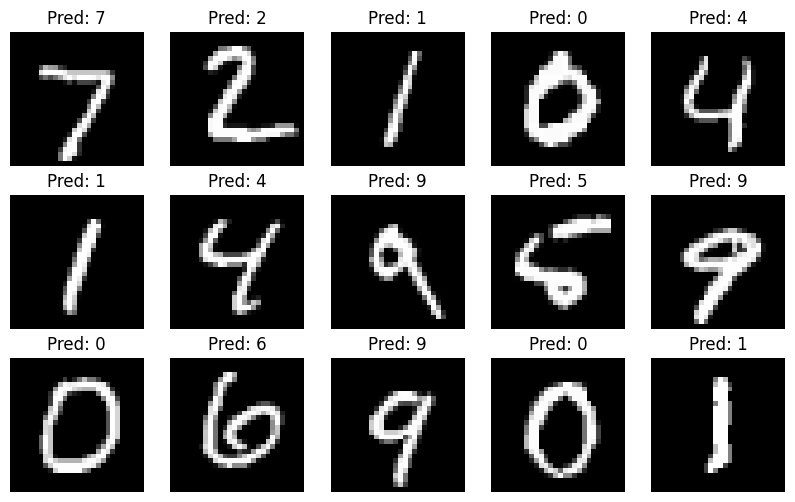

In [8]:
import numpy as np

# Get some test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict
model.eval()
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot images with predictions
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().numpy().squeeze()
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {preds[i].item()}")
    ax.axis("off")

plt.show()